# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from joblib import dump, load


df_cleaned = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
df_cleaned.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,548.0,RFn,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,460.0,RFn,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,608.0,RFn,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500.0
3,961.0,0.0,3.0,No,216.0,ALQ,540.0,642.0,Unf,1998.0,...,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970,140000.0
4,1145.0,0.0,4.0,Av,655.0,GLQ,490.0,836.0,RFn,2000.0,...,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000,250000.0


In [2]:
df_cleaned.dtypes

1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond       int64
OverallQual       int64
TotalBsmtSF     float64
YearBuilt         int64
YearRemodAdd      int64
SalePrice       float64
dtype: object

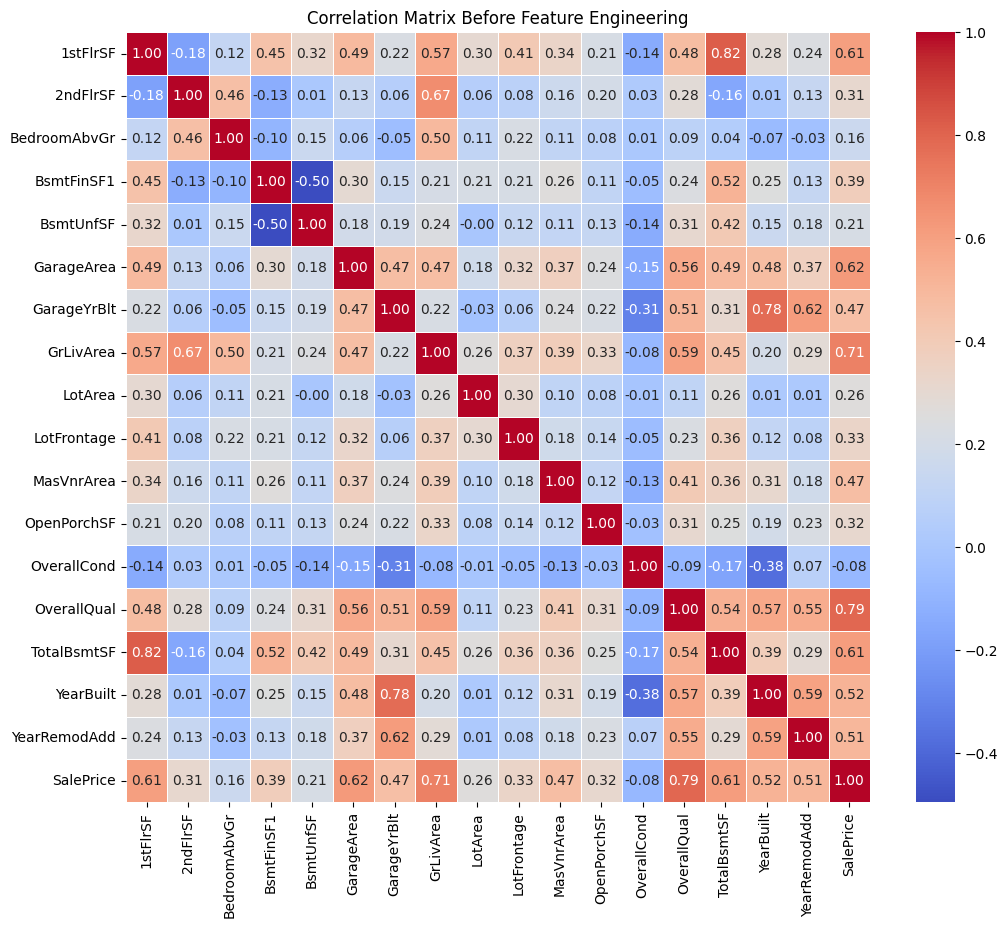

In [3]:
# Show the correlation matrix before feature engineering
correlation_matrix_before = df_cleaned.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()

**Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target "SalePrice" before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

Key Insights:

* **GrLivArea (0.71)** and **OverallQual (0.79)** have strong positive links to "SalePrice," making them important predictors.

* **GarageArea (0.62)** and **TotalBsmtSF (0.61)** also have strong positive links, showing that bigger garages and basements add value to house prices.

* **BedroomAbvGr (0.16)** and **OverallCond (-0.08)** have weak links to "SalePrice". These may be improved, combined, or removed.

___

Remove features with negative correlation to SalesPrice.

In [4]:
# Filter features with negative correlation with SalePrice
negative_corr_features = correlation_matrix_before['SalePrice'][correlation_matrix_before['SalePrice'] < 0].index.tolist()

# Print features with negative correlations
print("Features with negative correlation to SalePrice:")
print(negative_corr_features)

# Remove these features from the cleaned dataset
df_cleaned = df_cleaned.drop(columns=negative_corr_features)
print(f"Dataset shape after removing negative correlation features: {df_cleaned.shape}")

Features with negative correlation to SalePrice:
['OverallCond']
Dataset shape after removing negative correlation features: (1460, 21)


In [5]:
def compare_transformations(df, variable):
    """
    Perform and visualize various transformations for a specific variable during EDA.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the variable.
    - variable (str): The name of the variable to analyze.
    
    Returns:
    None. Displays histograms, QQ-plots, and boxplots for various transformations.
    """
    original = df[variable].dropna()  # Handle NaN values

    # Shift negative values for Box-Cox
    if original.min() <= 0:
        shift_value = abs(original.min()) + 1
        print(f"Shifting {variable} by {shift_value} for Box-Cox transformation.")
        original += shift_value

    # Apply transformations
    transformations = {
        "Original": original,
        "Log": np.log1p(original),
        "Box-Cox": BoxCoxTransformer(variables=[variable]).fit_transform(original.to_frame())[variable],
        "Yeo-Johnson": YeoJohnsonTransformer(variables=[variable]).fit_transform(original.to_frame())[variable]
    }

    # Plot results
    fig, axes = plt.subplots(len(transformations), 3, figsize=(15, 5 * len(transformations)))
    fig.suptitle(f"Transformation Analysis for {variable}", fontsize=16, y=1.02)
    
    for i, (name, transformed) in enumerate(transformations.items()):
        # Histogram
        axes[i, 0].hist(transformed, bins=30, alpha=0.7)
        axes[i, 0].set_title(f"{name} - Histogram")
        
        # QQ-plot
        stats.probplot(transformed, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title("QQ-Plot")
        
        # Boxplot
        axes[i, 2].boxplot(transformed, vert=False)
        axes[i, 2].set_title("Boxplot")
    
    plt.tight_layout()
    plt.show()

Analyzing transformations for: GrLivArea


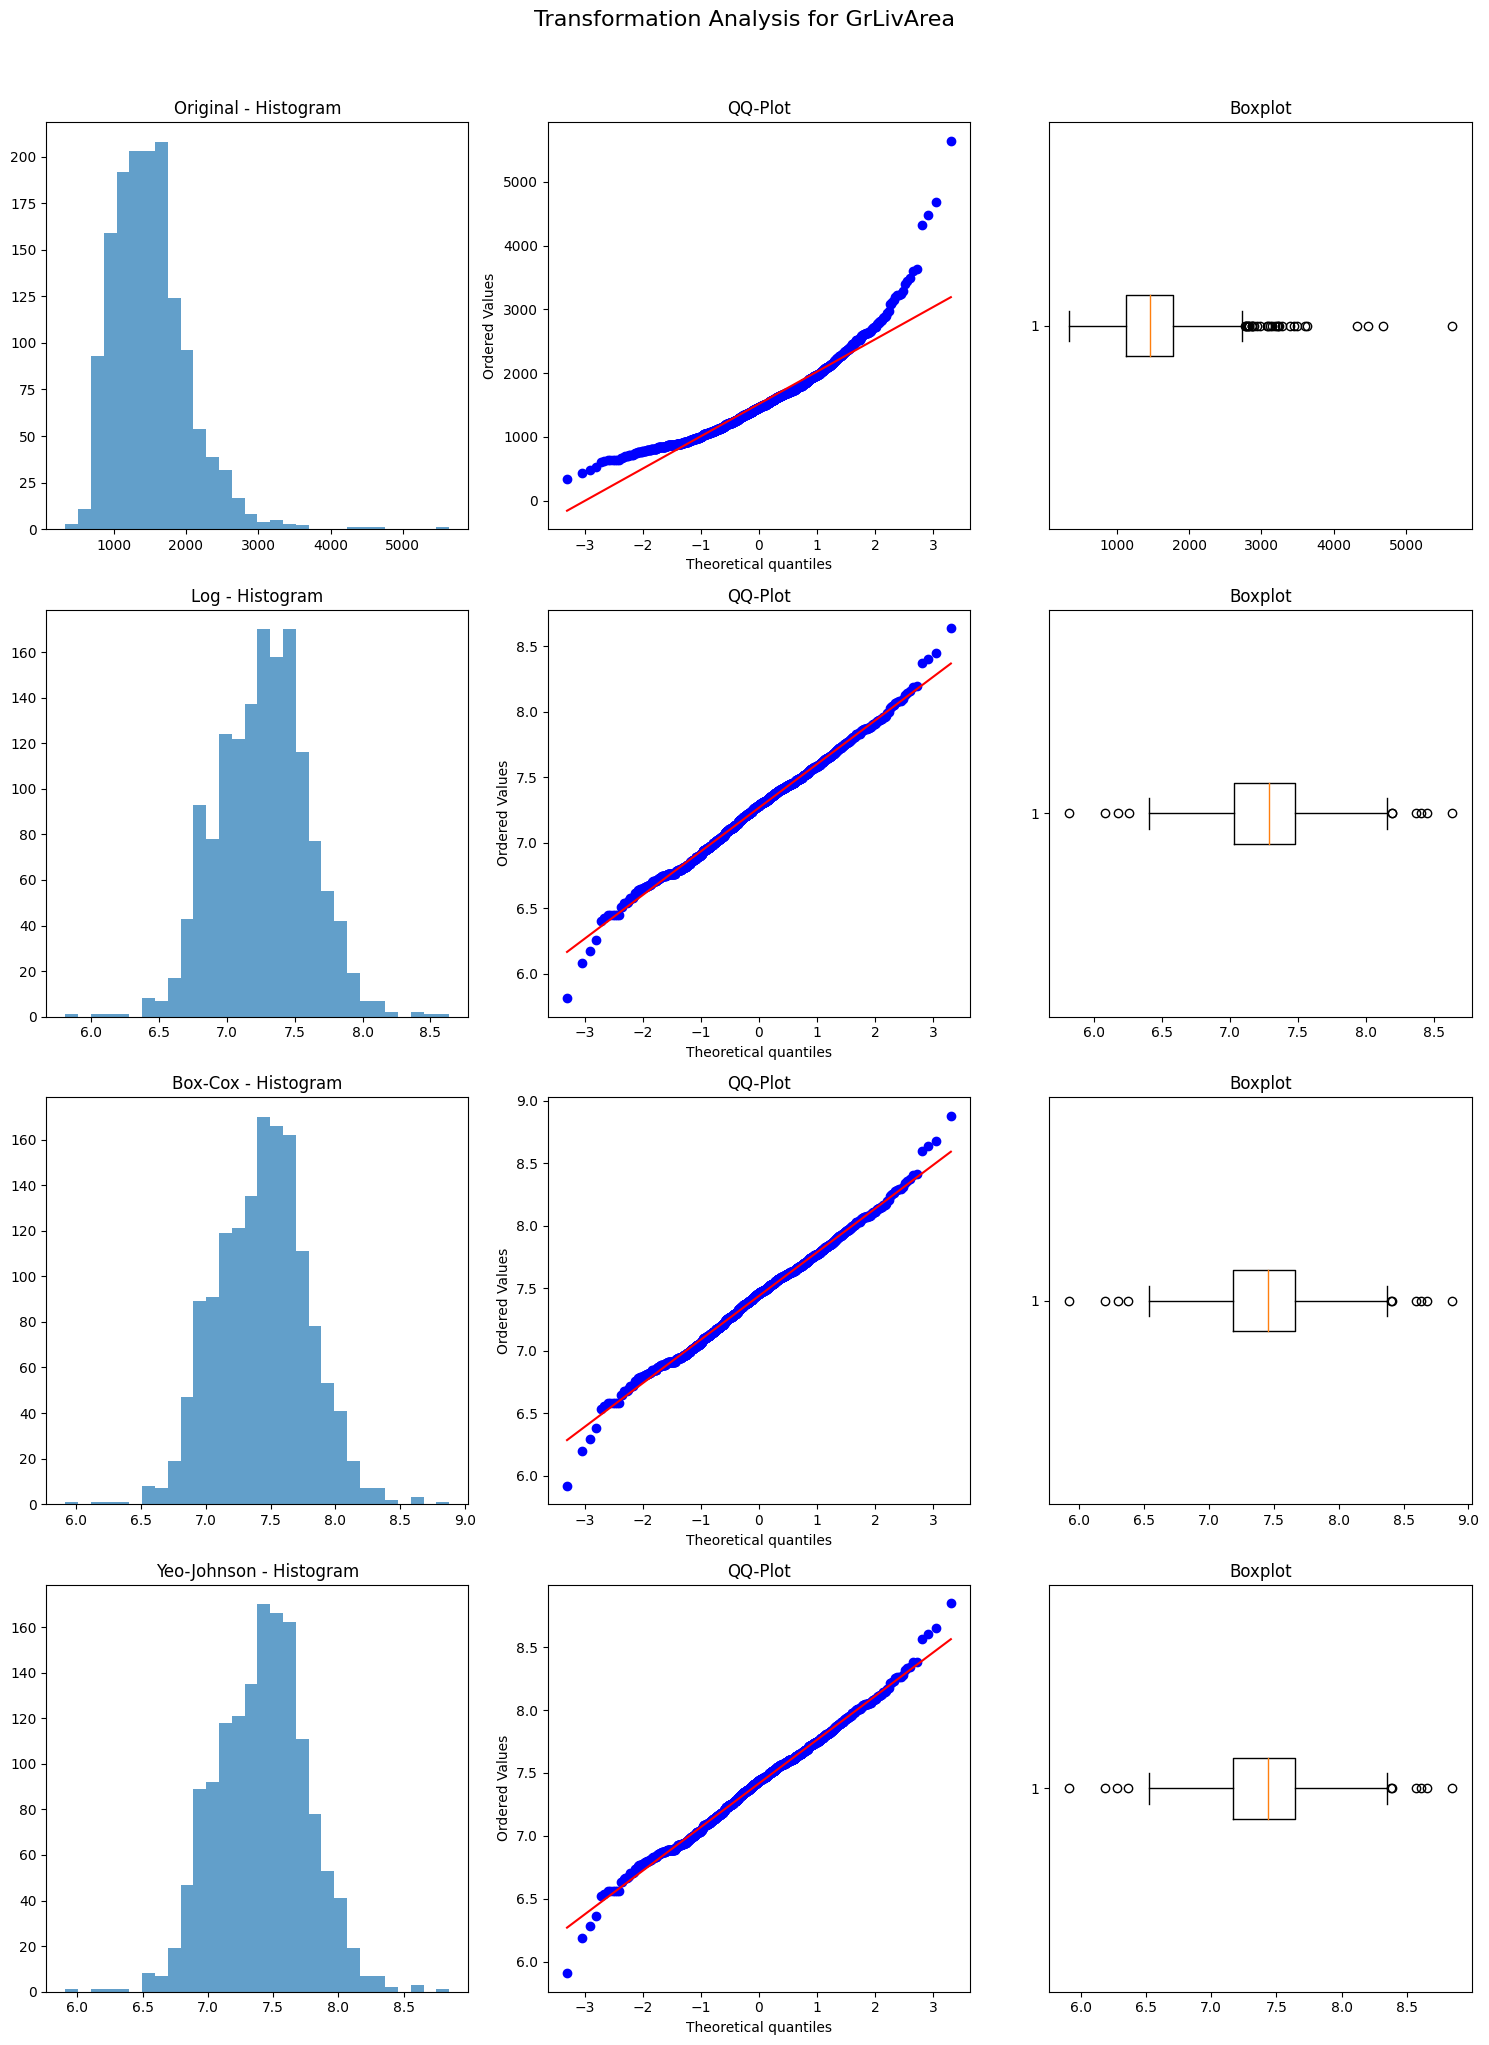

Analyzing transformations for: OverallQual


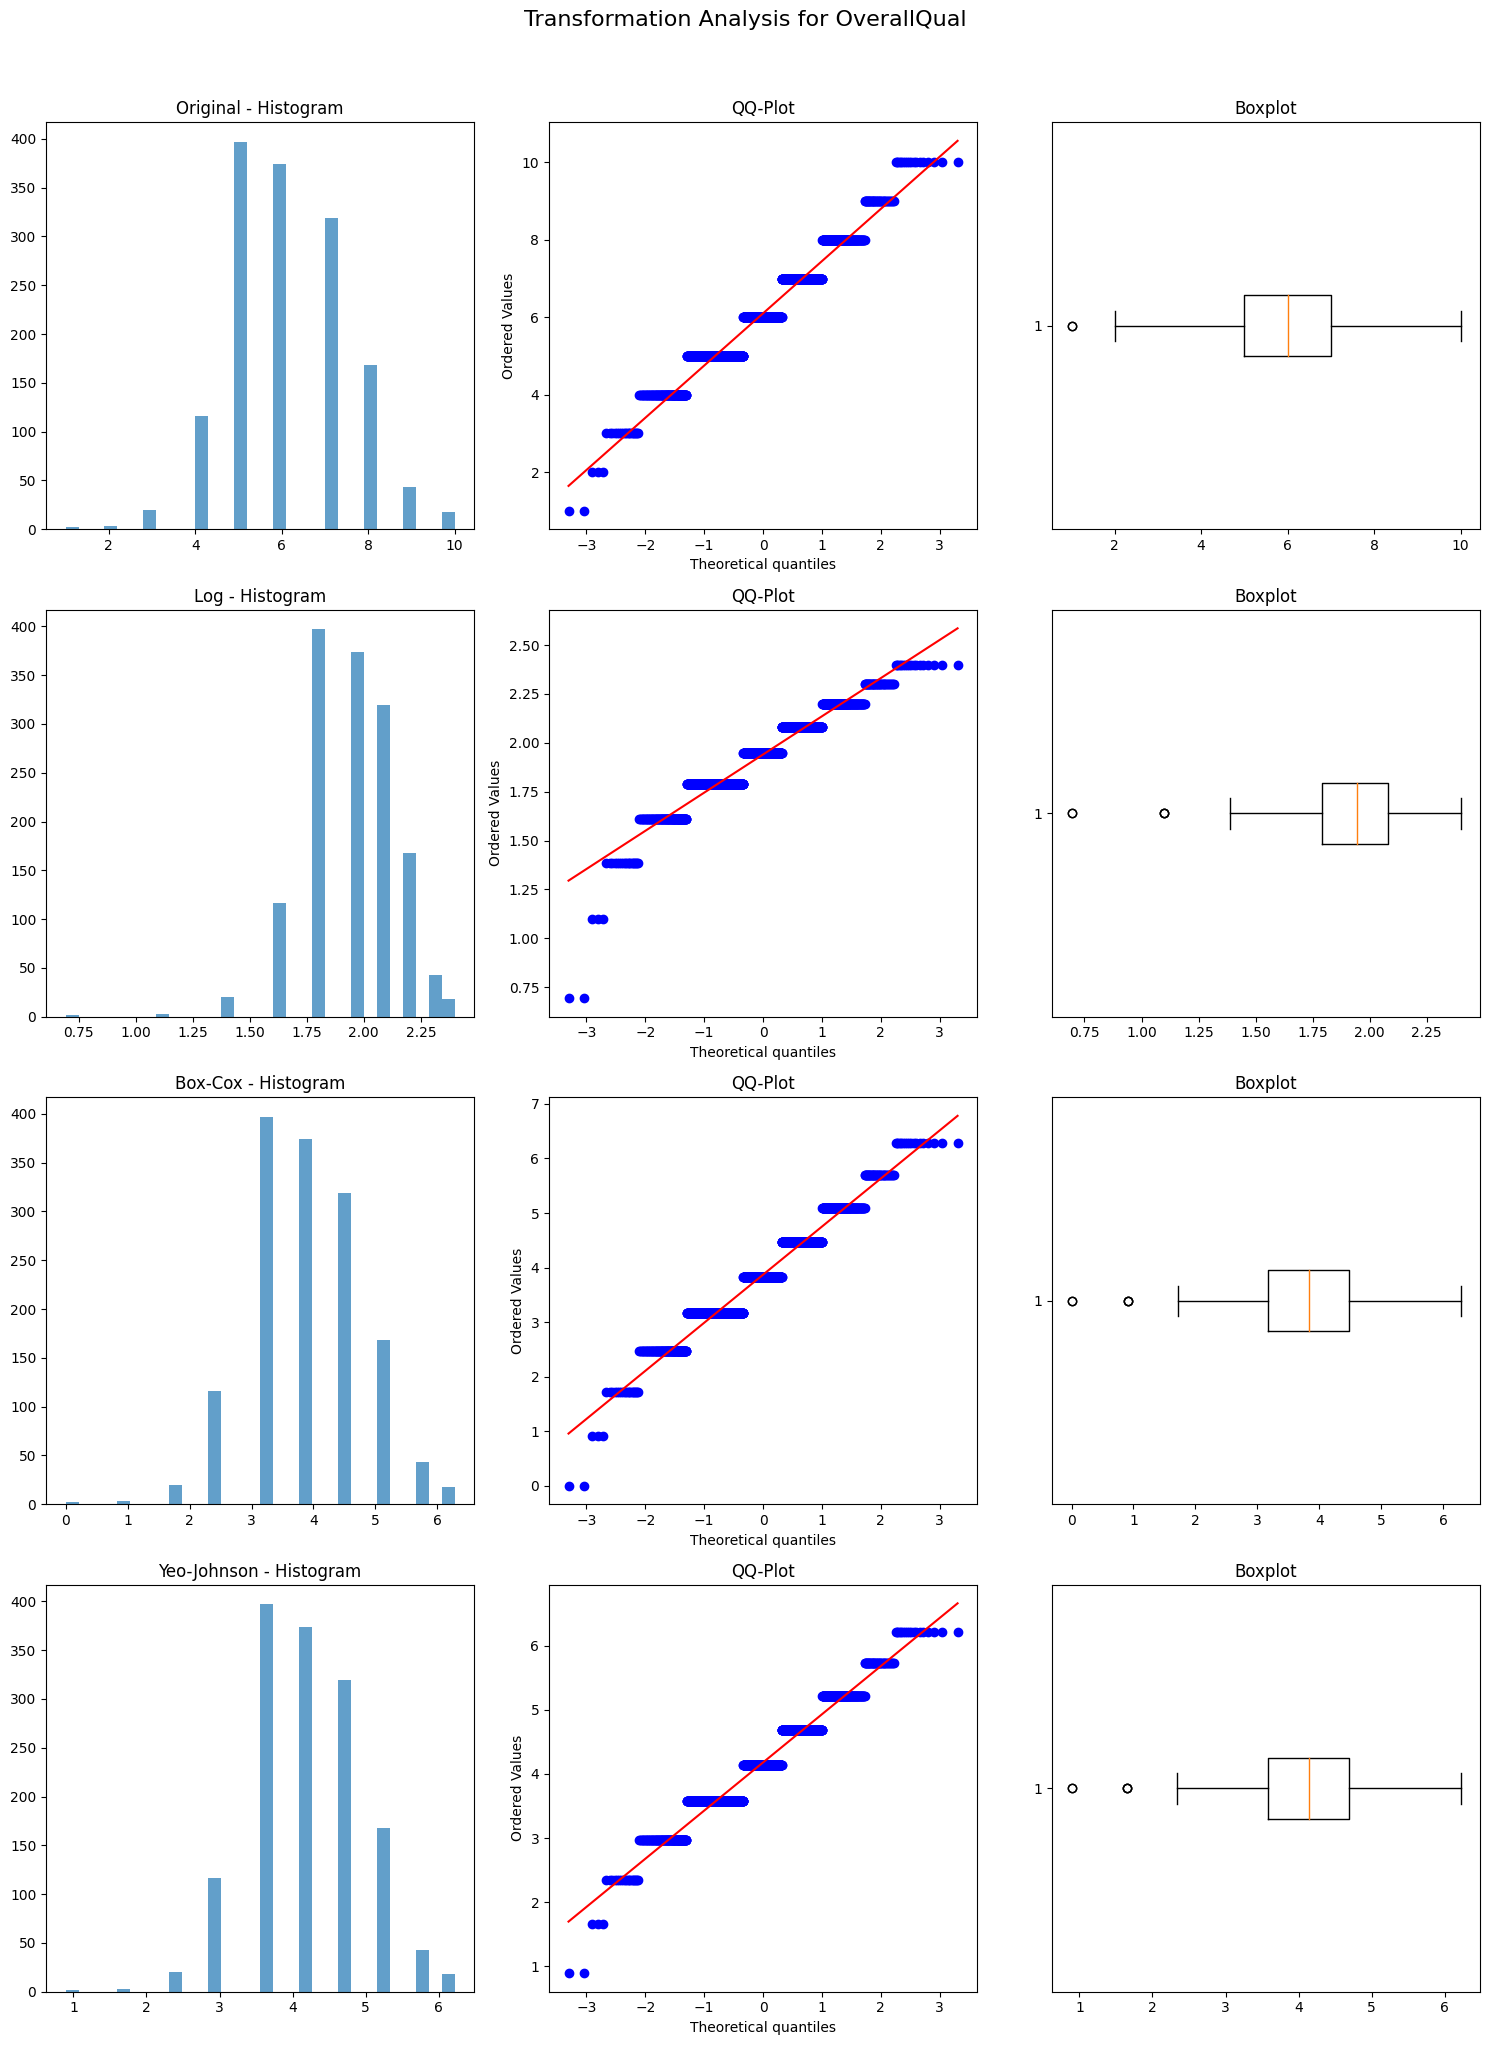

Analyzing transformations for: GarageArea
Shifting GarageArea by 1.0 for Box-Cox transformation.


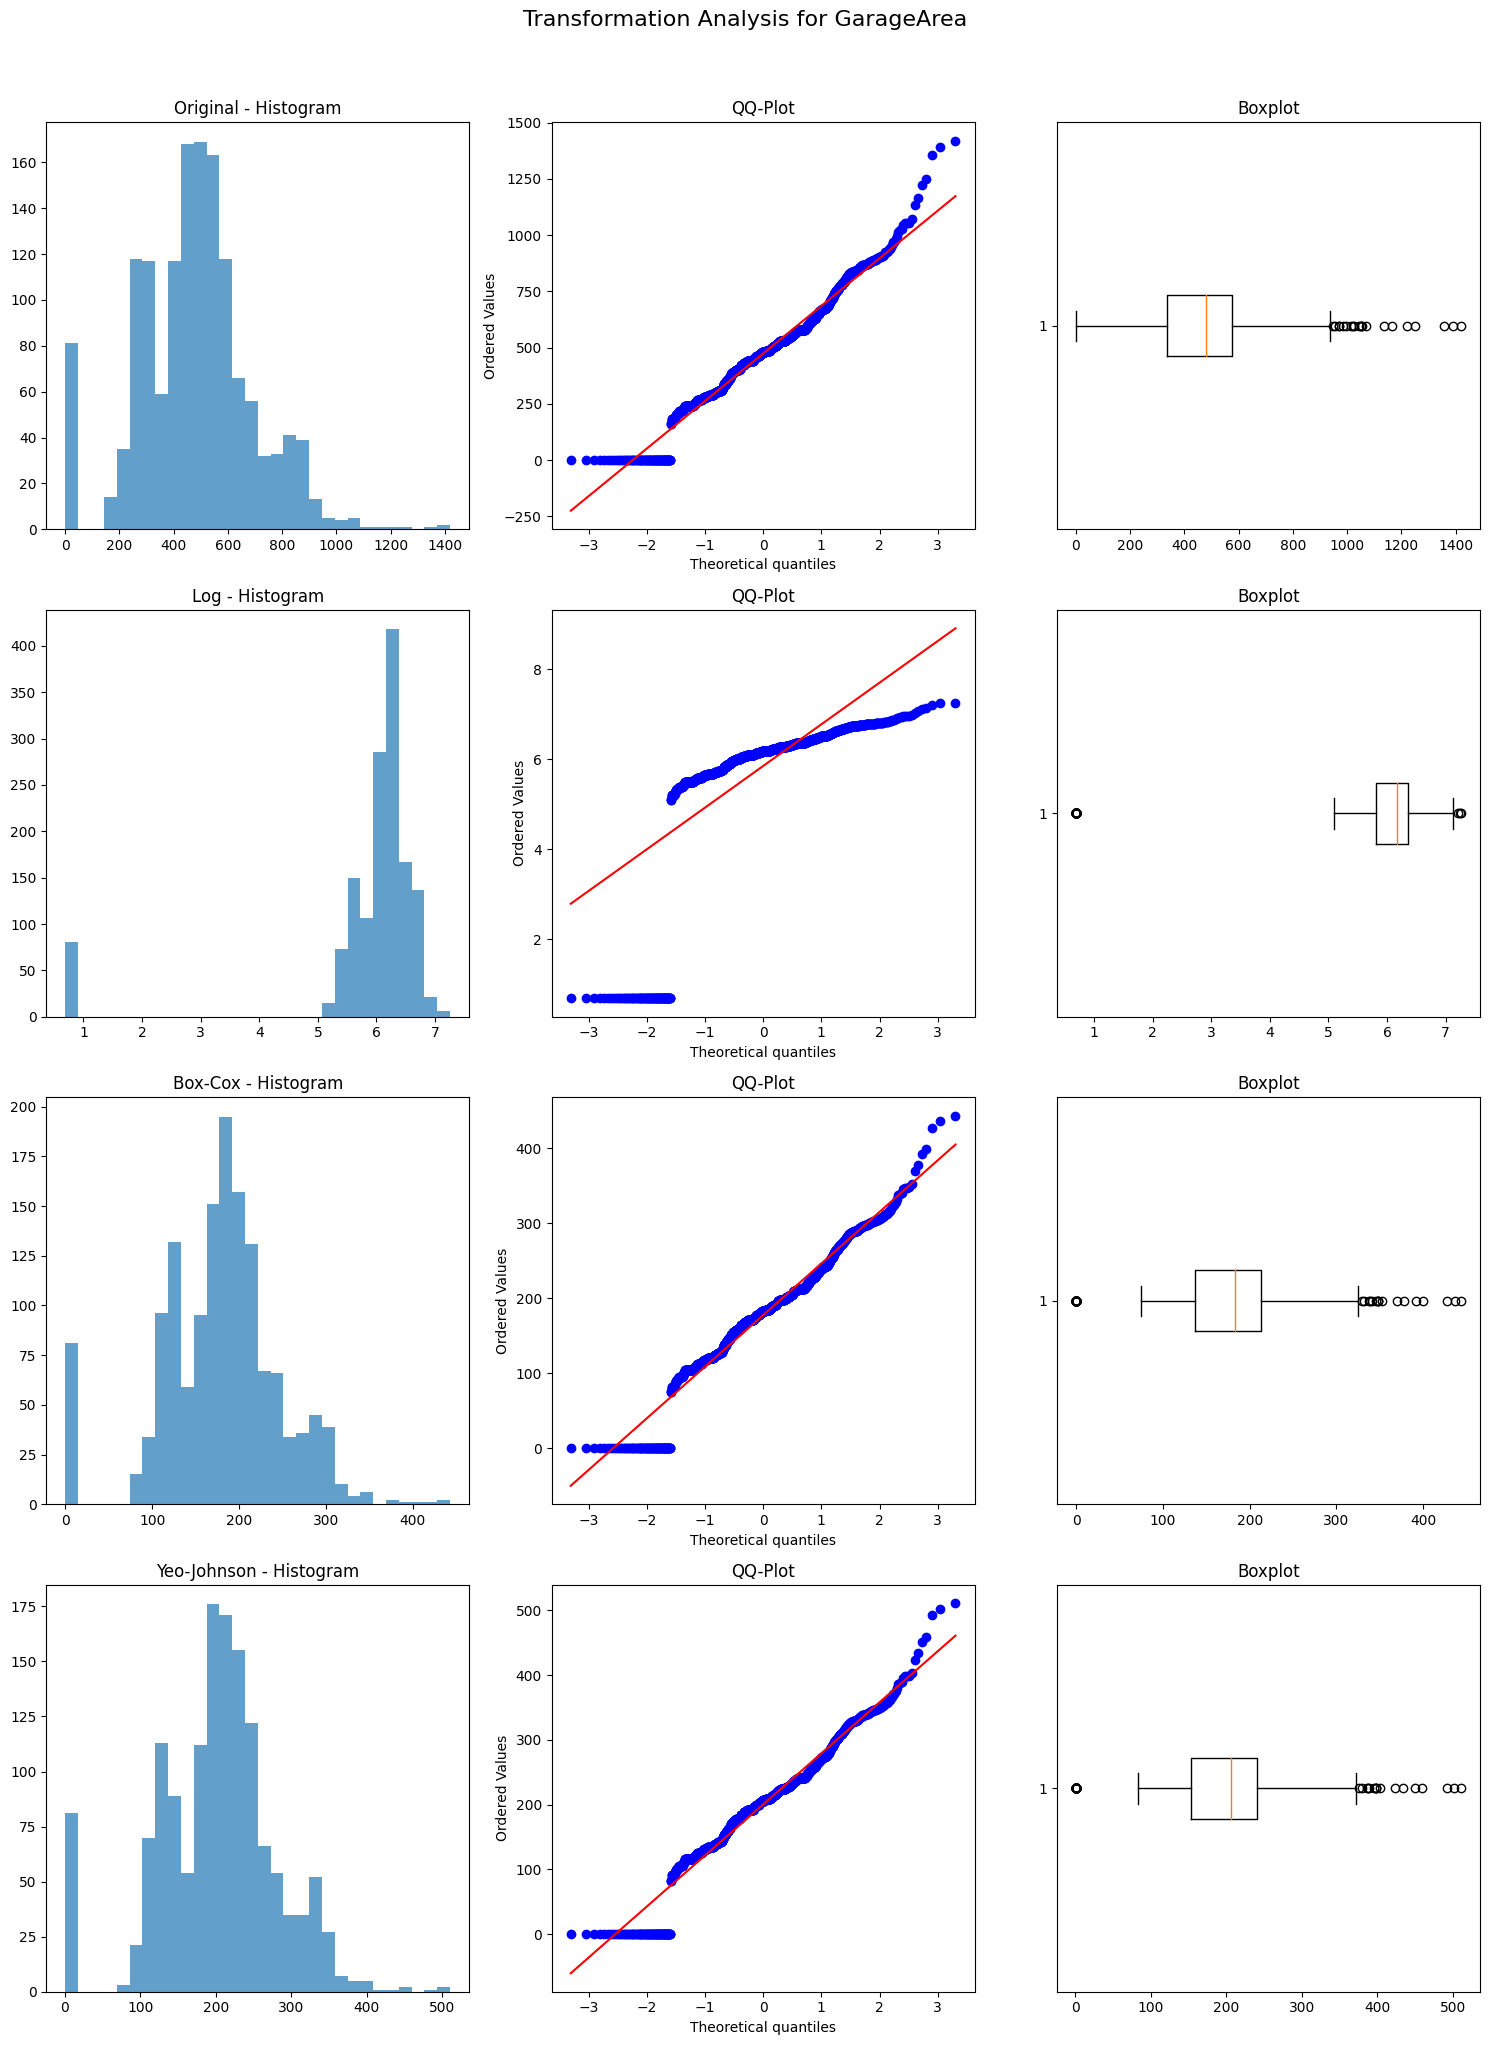

Analyzing transformations for: TotalBsmtSF
Shifting TotalBsmtSF by 1.0 for Box-Cox transformation.


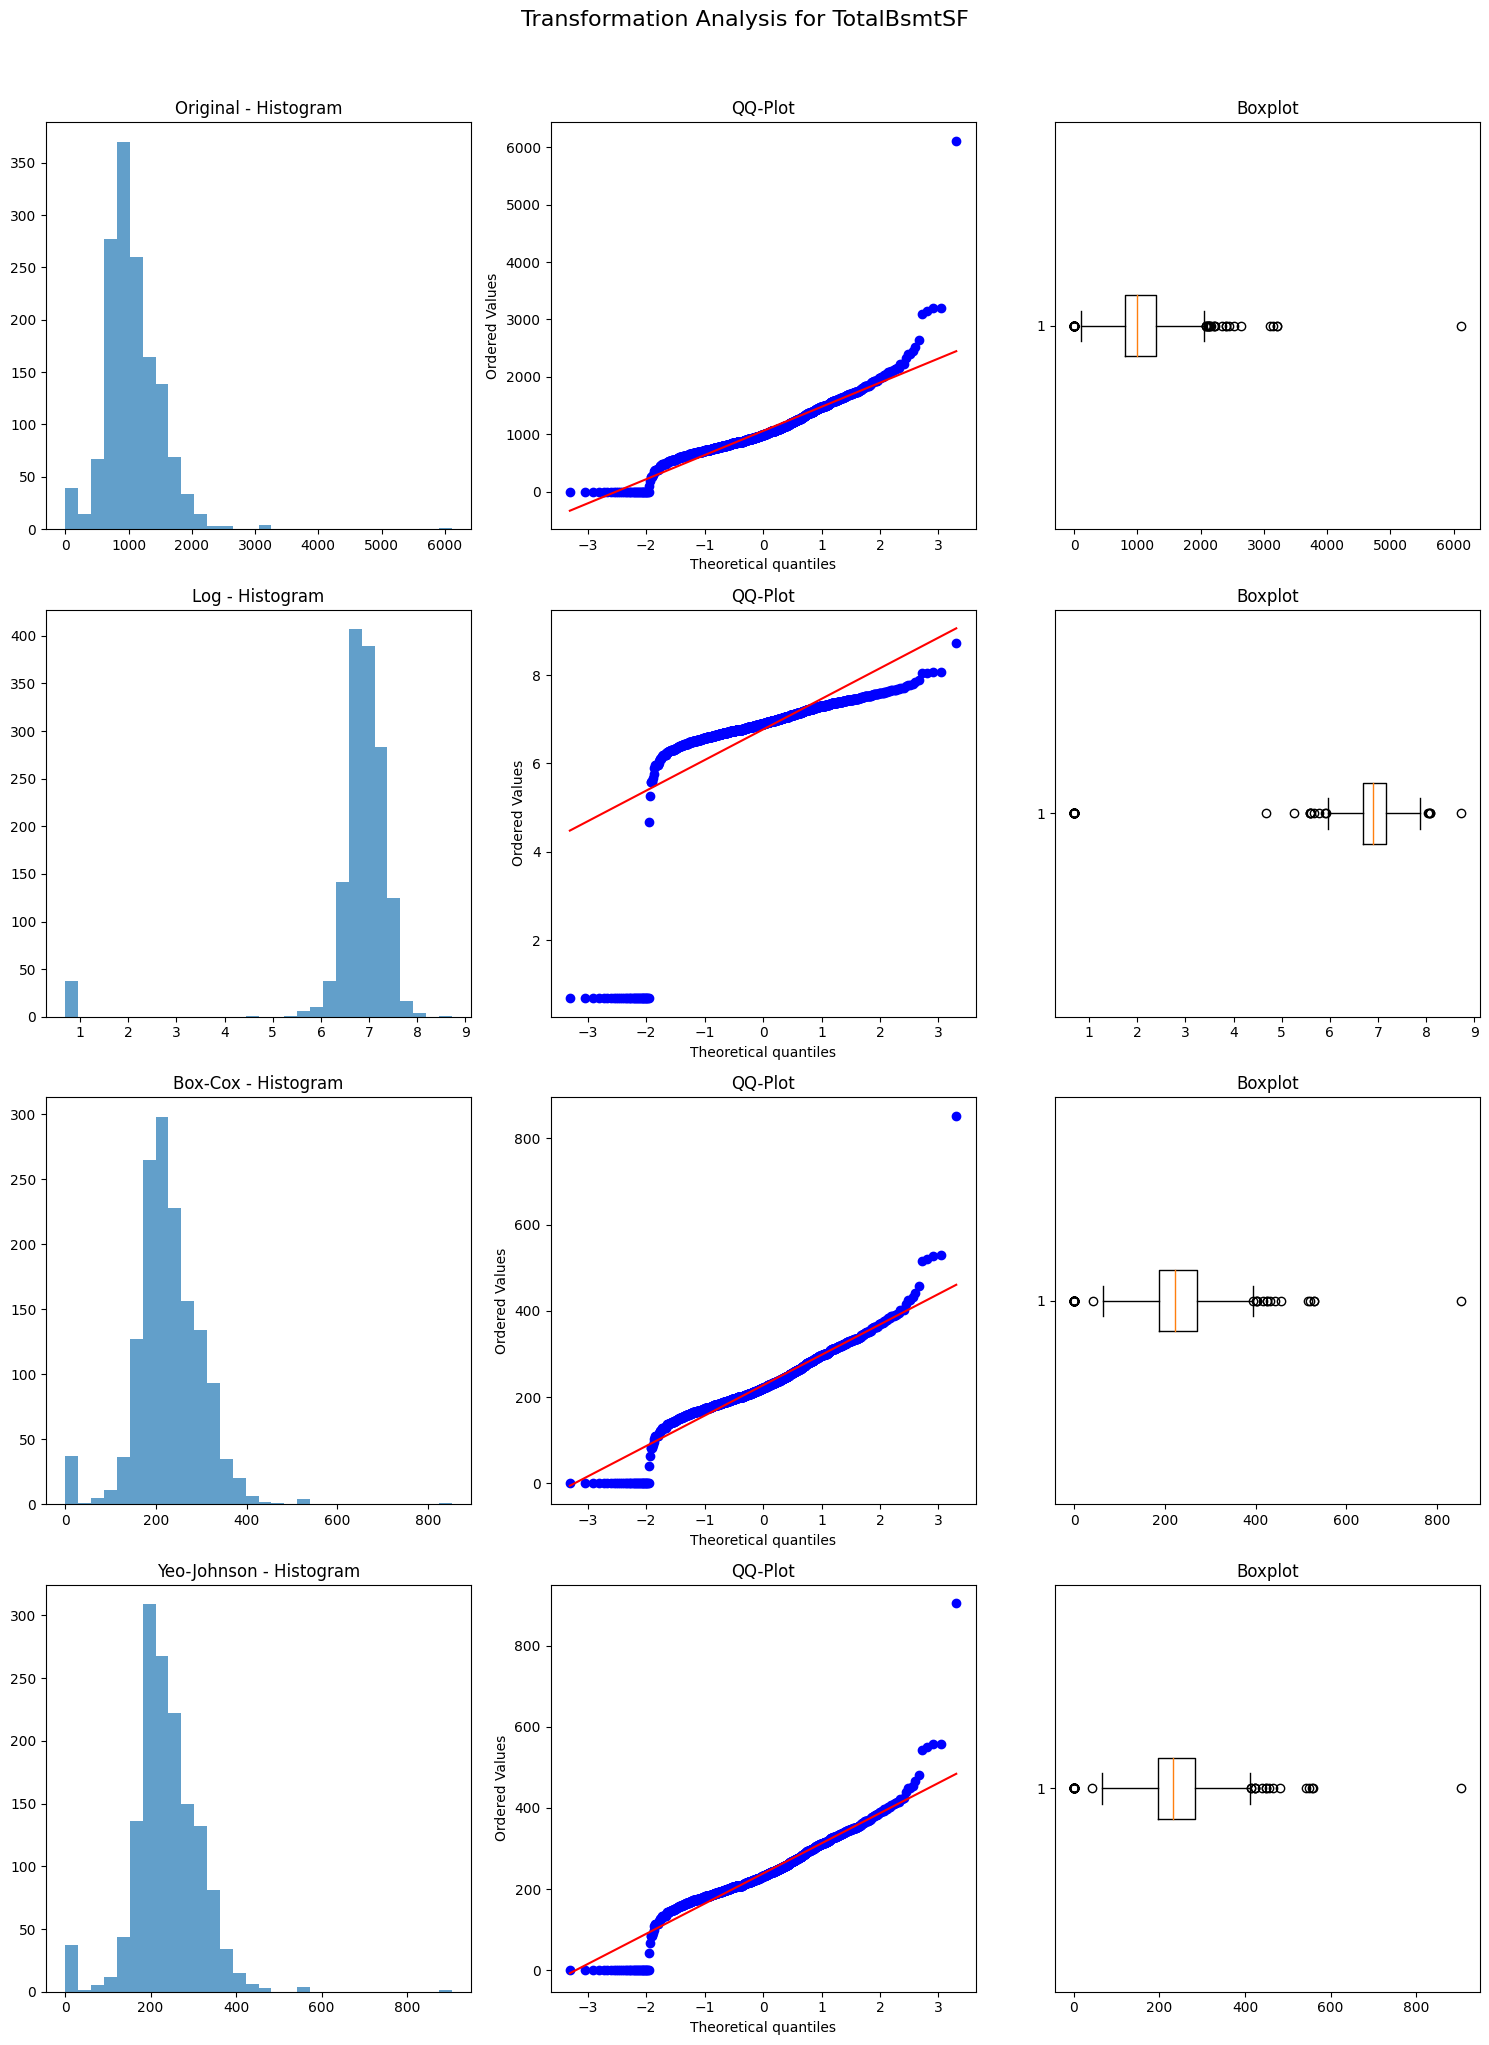

Analyzing transformations for: YearBuilt


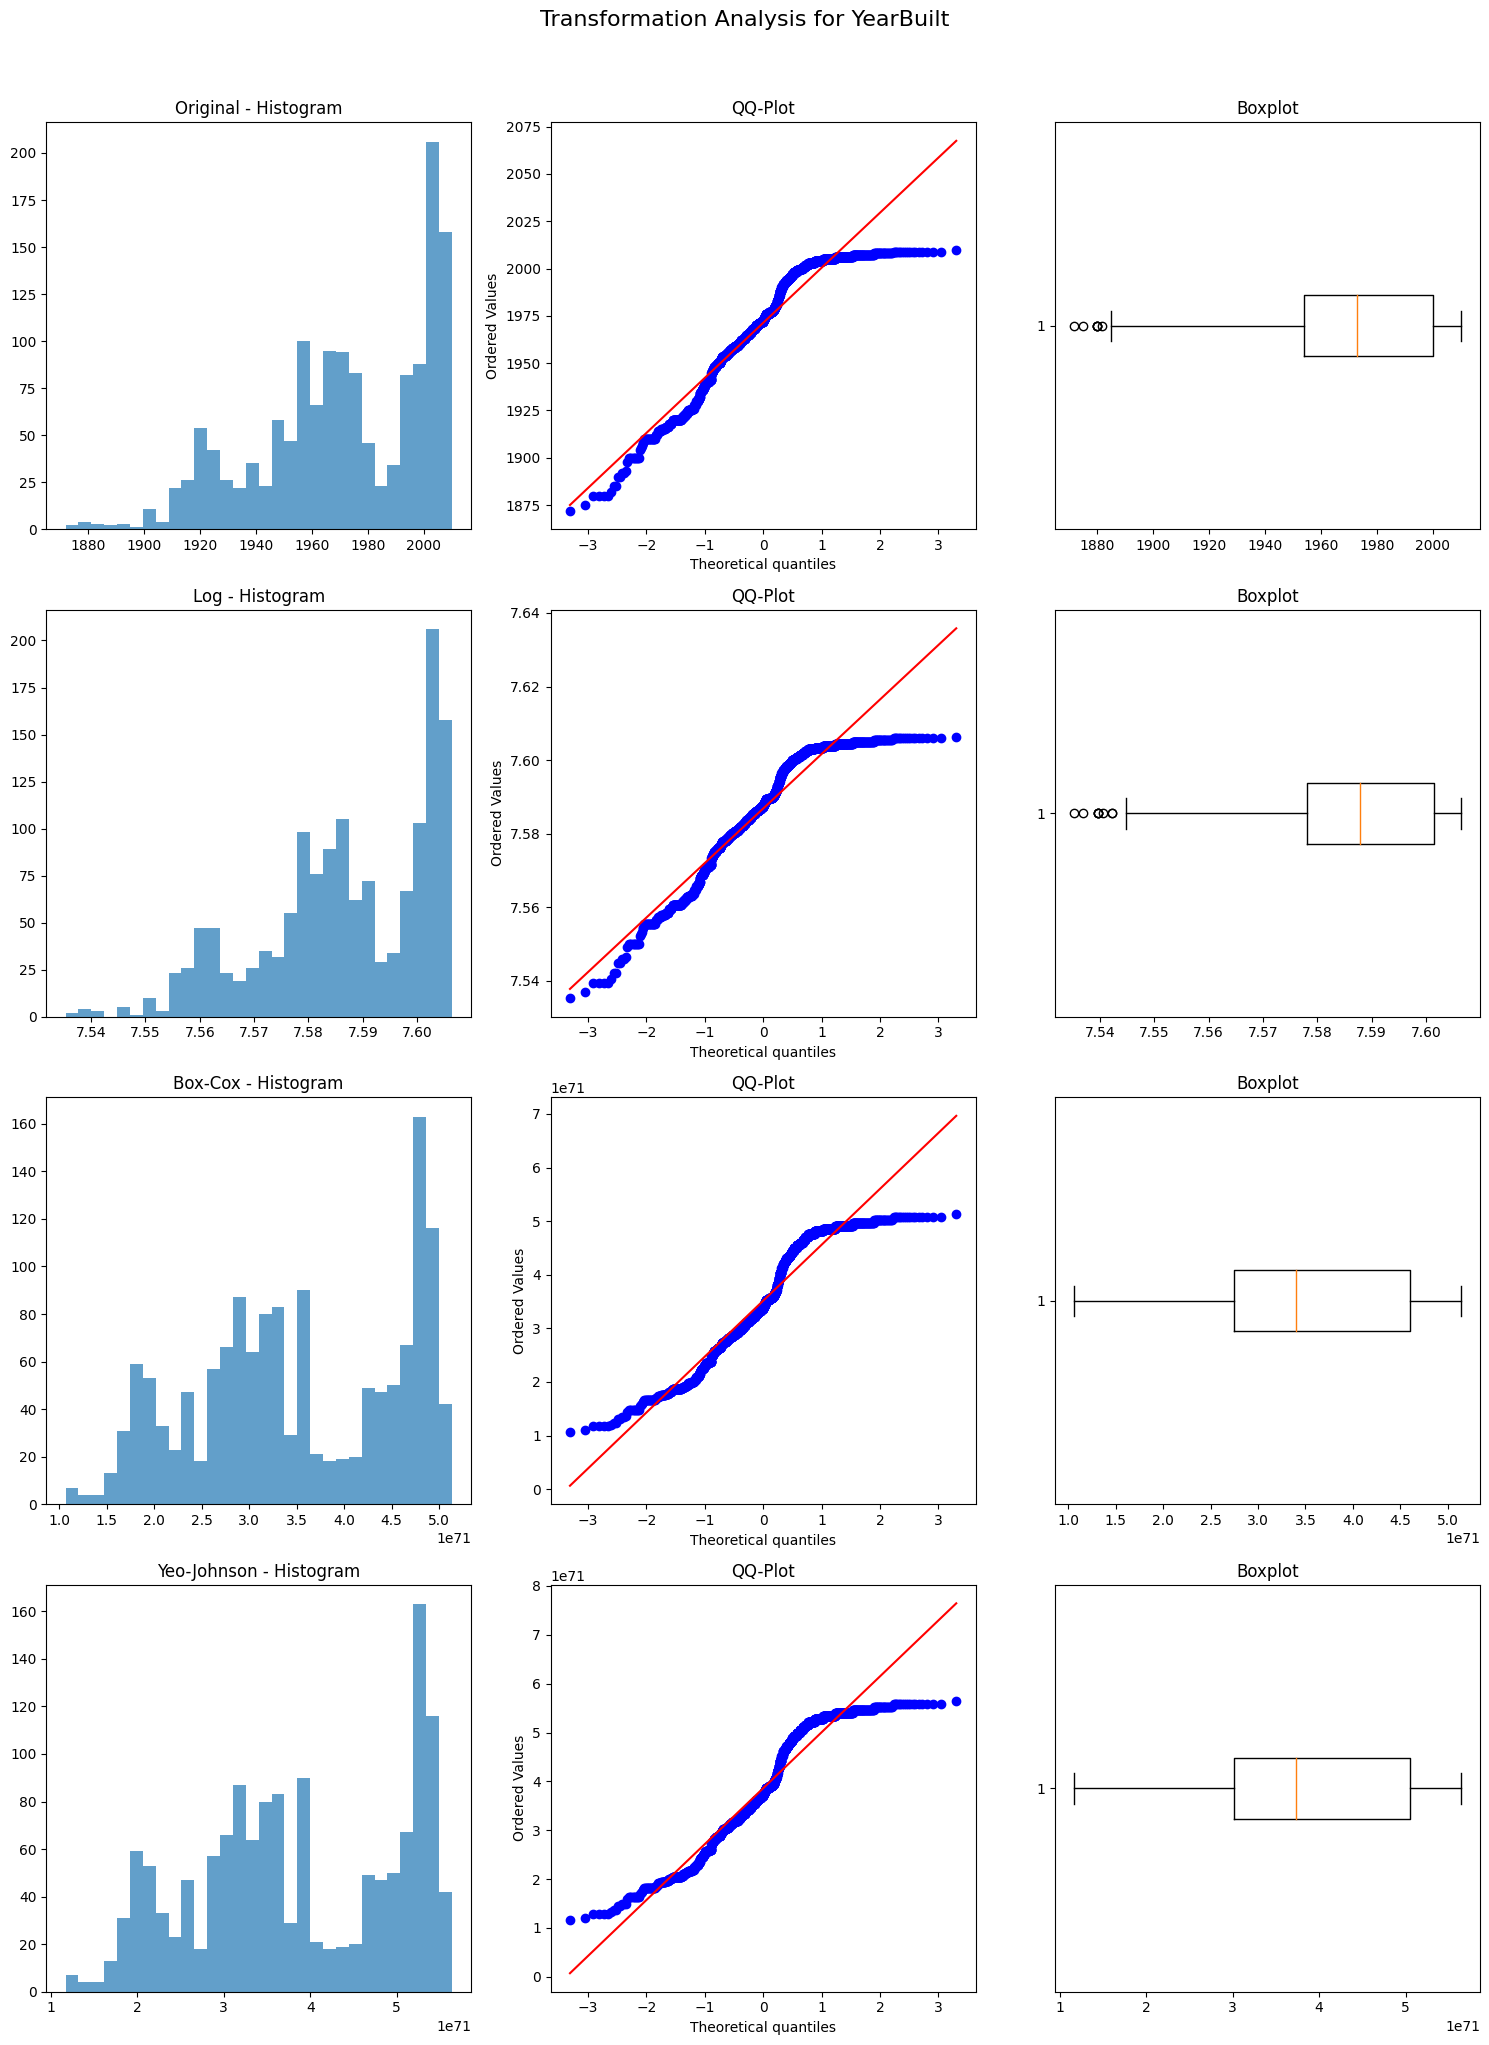

Analyzing transformations for: 1stFlrSF


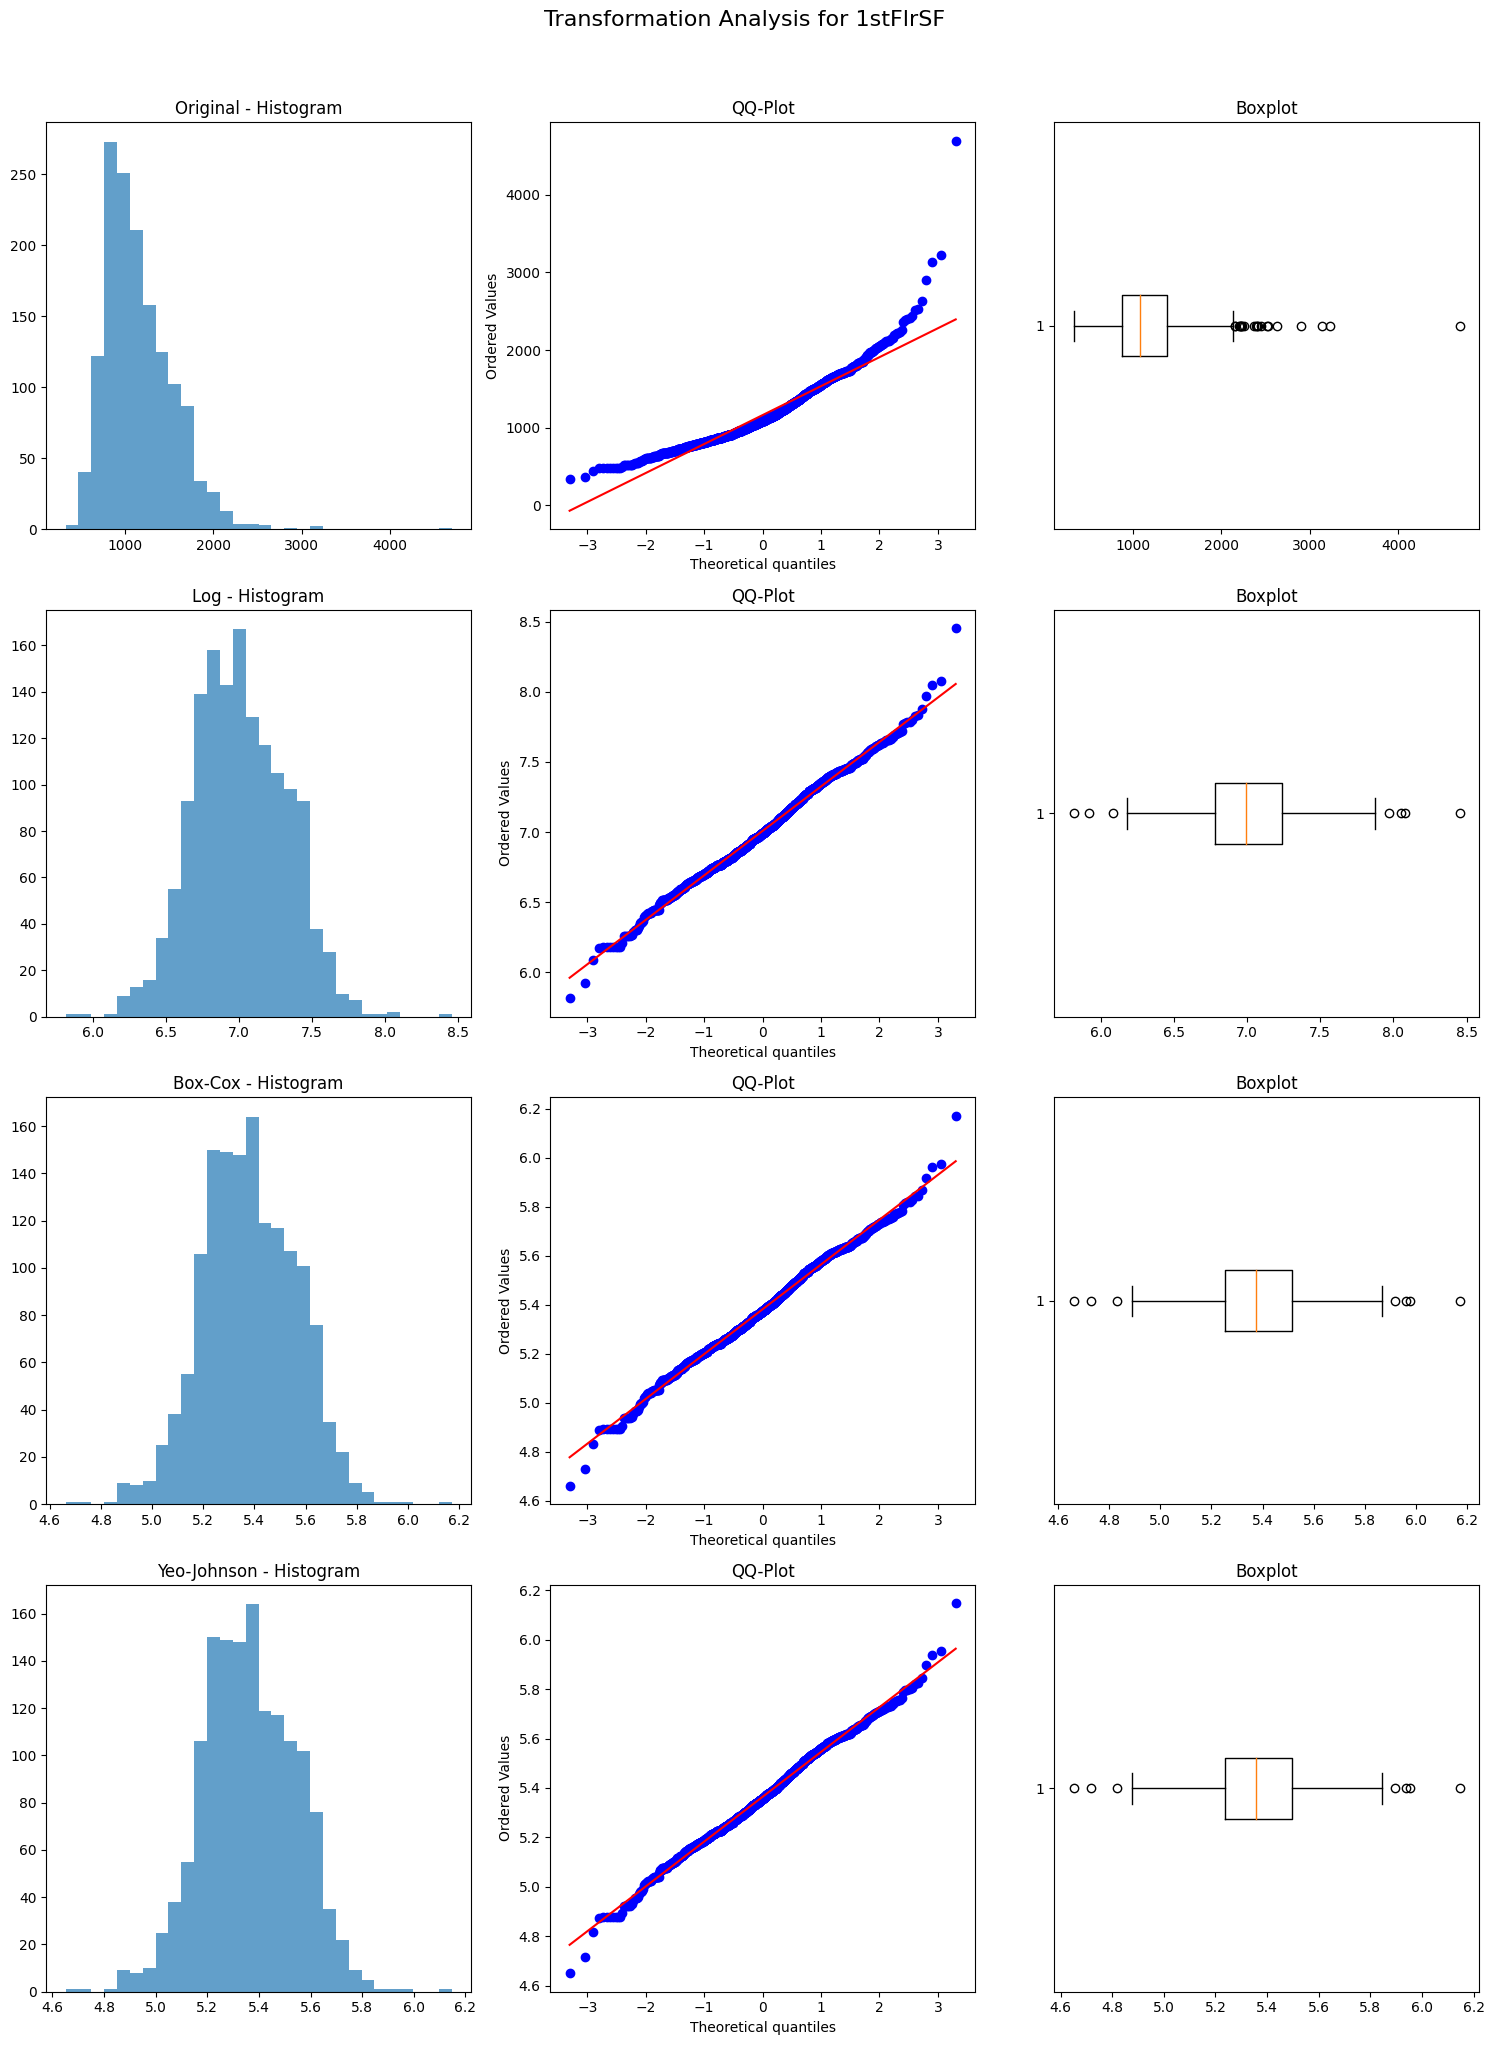

In [6]:
# Analyze transformations for strongly correlated variables
strong_corr_variables = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt','1stFlrSF']

for variable in strong_corr_variables:
    print(f"Analyzing transformations for: {variable}")
    compare_transformations(df_cleaned, variable)

* **GrLivArea** and **TotalBsmtSF** Both have skewed distributions, which can negatively affect the model. The Box-Cox transformation works well here, as it reduces skewness and the impact of extreme values. This should help the model better understand these variables.

* **OverallQual** This is a categorical variable representing house quality. Since it already has a discrete structure, transformations don’t improve it. I’m keeping it as is, as it provides meaningful levels directly to the model.

* **GarageArea** This variable has some skewness and can include zero values. Yeo-Johnson is the best choice here because it handles zeros and smooths the distribution effectively, which should improve model performance.

* **YearBuilt** This variable is based on time, so having a perfect normal distribution isn’t very important. However, the Box-Cox transformation makes the data smoother. I might also group the years into categories to help the model find patterns more easily.

UPDATE!!!

___

### Hypothesis 1

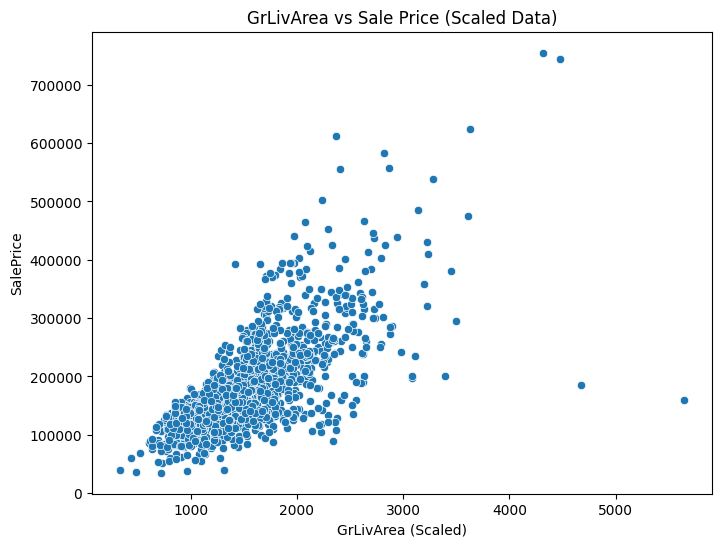

In [16]:
# Plot GrLivArea vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_transformed )
plt.xlabel('GrLivArea (Scaled)')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price (Scaled Data)')
plt.show()

### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming the initial hypothesis that bigger houses tend to have higher sale prices.

___

### Hypothesis 2

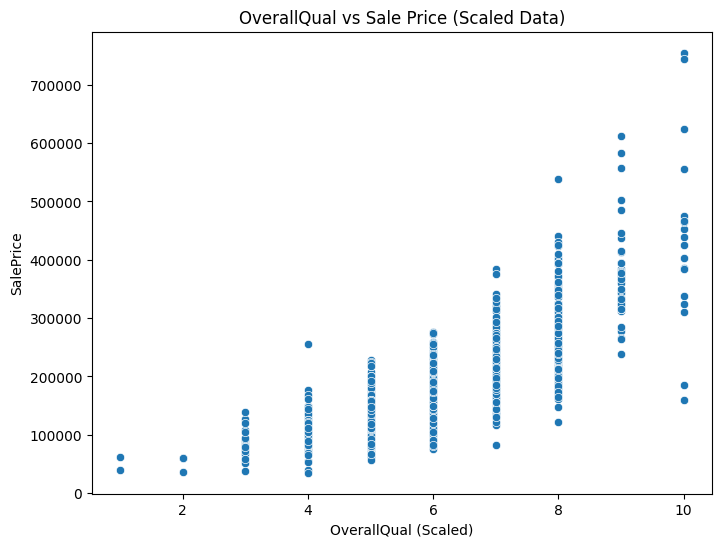

In [17]:
# Plot OverallQual vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_transformed )
plt.xlabel('OverallQual (Scaled)')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price (Scaled Data)')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.79, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

___

### Hypothesis 3

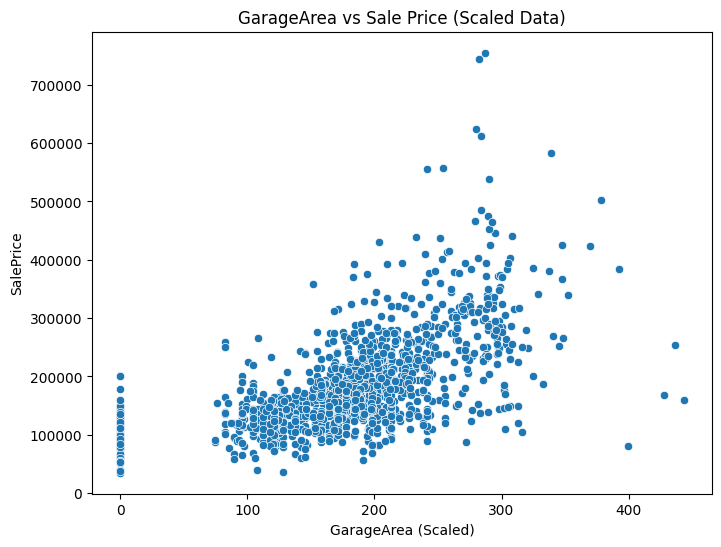

In [18]:
# Plot GarageArea vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=df_transformed )
plt.xlabel('GarageArea (Scaled)')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price (Scaled Data)')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

___

___

In [7]:
# Select only numeric columns from the cleaned DataFrame
df_cleaned_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_cleaned_numeric.corr()

# Identify features that have a high correlation with 'SalePrice'
threshold = 0.4
high_corr_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold].index.tolist()
print("Features with high correlation > 0.4:", high_corr_features)

# Create X_combined (features) with high correlation and y_combined ('SalePrice' target)
X_combined = df_cleaned_numeric[high_corr_features].drop(columns=['SalePrice'])
y_combined = df_cleaned_numeric['SalePrice']


Features with high correlation > 0.4: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'MasVnrArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


Top 5 features based on importance:
       Feature  Importance
5  OverallQual    0.575233
3    GrLivArea    0.253178
6  TotalBsmtSF    0.092234
1   GarageArea    0.047012
0     1stFlrSF    0.040896


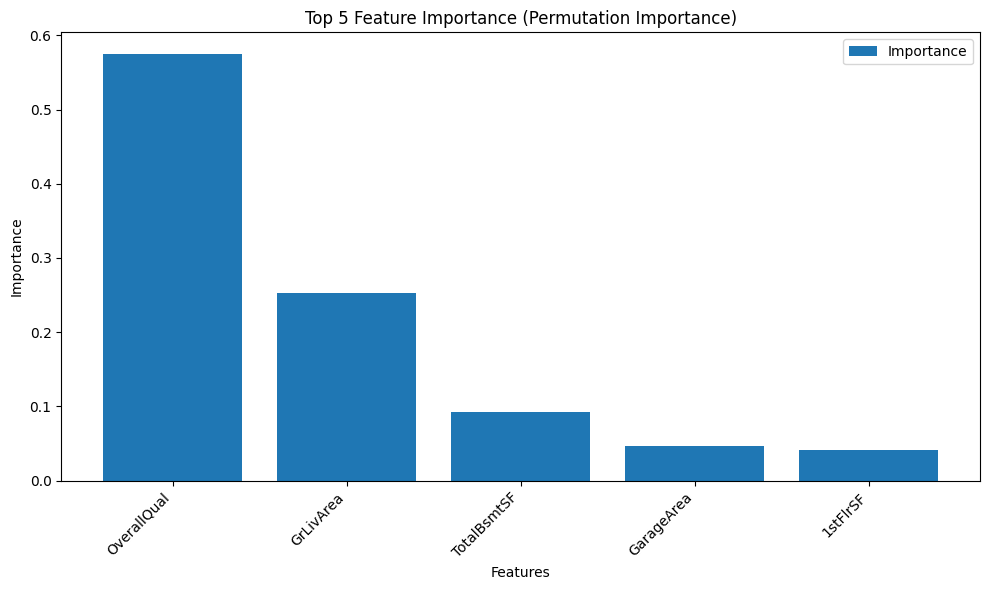

Selected features: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF']


In [32]:
# Model training
model = RandomForestRegressor(random_state=42)
model.fit(X_combined, y_combined)

# Feature importance
perm_importance = permutation_importance(model, X_combined, y_combined, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Sort by weight
top_features = importance_df.nlargest(5, 'Importance')

# Print top 5
print("Top 5 features based on importance:")
print(top_features)

# Plot feature importance (topp 5)
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Importance'], label="Importance")
plt.xticks(rotation=45, ha='right')
plt.title('Top 5 Feature Importance (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()

# Save the plot as a PNG
output_path = 'outputs/pipelines/feature_importance.png'
plt.savefig(output_path)
plt.show()

# Select features with importance > 0.03
selected_features = importance_df[importance_df['Importance'] > 0.04]['Feature'].tolist()
print("Selected features:", selected_features)



* **Encode categorical variables:** Turn category columns into numbers so the model can use them.
* **Boolean columns:** Change True/False to 0 and 1 for the model.
* **Separate columns:** Split numeric and category columns to handle them better, like scaling numbers.

In [33]:
# Define the functions used
selected_features = [
    'GarageArea',     # 1
    'GrLivArea',      # 2
    'TotalBsmtSF',    # 3
    'OverallQual',    # 4
    '1stFlrSF',       # 5
    'SalePrice'
]
df_selected = df_cleaned[selected_features]

# Create the transformation pipeline
transformer = ColumnTransformer(
    transformers=[
        ('yeo_johnson', YeoJohnsonTransformer(variables=['GarageArea']), ['GarageArea']),
        ('scaler', StandardScaler(), ['GrLivArea', 'TotalBsmtSF']),
        ('passthrough', 'passthrough', ['OverallQual', '1stFlrSF'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Create pipeline
pipeline = Pipeline([
    ('feature_transformation', transformer)
])

# Train the pipeline
pipeline.fit(df_selected.drop(columns=['SalePrice']))
print("Pipeline trained successfully.")

# Save the pipeline
pipeline_path = "outputs/pipelines/feature_pipeline_cleaned.pkl"
dump(pipeline, pipeline_path)
print(f"Pipeline saved successfully at {pipeline_path}")

# Extract pipeline feature names
pipeline_features = pipeline.named_steps['feature_transformation'].get_feature_names_out()
pipeline_features_cleaned = [feat.split('__')[-1] for feat in pipeline_features]
print("Final feature order from pipeline:", pipeline_features_cleaned)

# Save the feature order
feature_order_path = "outputs/pipelines/feature_order.txt"
with open(feature_order_path, "w") as f:
    for feature in pipeline_features_cleaned:
        f.write(feature + "\n")

print(f"Feature order saved successfully at {feature_order_path}")


Pipeline trained successfully.
Pipeline saved successfully at outputs/pipelines/feature_pipeline_cleaned.pkl
Final feature order from pipeline: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF']
Feature order saved successfully at outputs/pipelines/feature_order.txt


In [34]:
# Transform the dataset
X_transformed = pipeline.transform(df_selected.drop(columns=['SalePrice']))

df_transformed = pd.DataFrame(X_transformed, columns=pipeline_features_cleaned)

# Add target variable
df_transformed['SalePrice'] = df_selected['SalePrice'].values

# Save the transformed dataset
output_path = "outputs/datasets/collection/HousePricesPredictionFeatures.csv"
df_transformed.to_csv(output_path, index=False)
print(f"Transformed dataset saved successfully at {output_path}.")


Transformed dataset saved successfully at outputs/datasets/collection/HousePricesPredictionFeatures.csv.


* Combine columns to put all the numeric and encoded category columns together in one dataset.
* Scale numbers to make all numeric values similar in range to help the model work better.

* Scale the numeric features so they are all on a similar range.
* Add 'SalePrice' to the transformed dataset.
* Print the dataset size, first few rows, and data types after transformation.
* Print an error message if something goes wrong.

In [36]:
# Load pipeline and dataset
pipeline = load("outputs/pipelines/feature_pipeline_cleaned.pkl")
df_transformed = pd.read_csv("outputs/datasets/collection/HousePricesPredictionFeatures.csv")

# Get pipeline features and remove prefix
pipeline_features = pipeline.named_steps['feature_transformation'].get_feature_names_out()
pipeline_features_cleaned = [feature.split('__')[-1] for feature in pipeline_features]  # Ta bort prefix
print(f"Cleaned pipeline features: {pipeline_features_cleaned}")

# Get features in the dataset
dataset_features = df_transformed.drop(columns=['SalePrice']).columns.tolist()
print(f"Features in the dataset for prediction: {dataset_features}")

# Validate if features match
if pipeline_features_cleaned == dataset_features:
    print("Features match in the exact same order!")
else:
    print("Features mismatch (name or order)!")
    ...

Cleaned pipeline features: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF']
Features in the dataset for prediction: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF']
Features match in the exact same order!


___

**Correlation Matrix After Feature Engineering**

The updated correlation matrix shows that feature engineering did not change the correlations between the features and the target variable **SalePrice**.

* **OverallQual (0.79)** This feature has the strongest positive correlation with SalePrice, indicating that higher-quality homes tend to sell for more. This makes it a key predictor for the model.

* **GrLivArea (0.70)** and **GarageArea (0.61)** Both still show strong positive correlations with SalePrice, showing they are important for predicting house prices.

The feature engineering process aimed to explore new predictors and reduce redundancy, but the existing features remain the most significant contributors to the model. By focusing on strongly correlated features like OverallQual, GrLivArea, and GarageArea, the model can effectively predict house prices while avoiding the inclusion of less impactful features.

# Reasoning for Selected Features

After analyzing correlations, building the pipeline, and calculating feature importance, 
I decided to include the following features in the model:

1. **GrLivArea** (Above Ground Living Area)
   - This feature has a strong correlation with **SalePrice (0.71)** and was the second most important in the feature importance analysis.
   - Larger living areas above ground often increase house value, making this a reliable predictor.

2. **OverallQual** (Overall Quality of the House)
   - This feature has the highest correlation with **SalePrice (0.79)** and is the most important feature based on importance scores.
   - Houses with better overall quality sell for higher prices, so it’s essential for the model.

3. **TotalBsmtSF** (Total Basement Area)
   - This feature has a strong correlation with **SalePrice (0.61)** and was ranked third in importance.
   - A larger basement adds both functional and market value, making it a key feature.

4. **YearRemodAdd** (Year of Last Remodel/Additions)
   - This feature has a moderate correlation with **SalePrice (0.51)** and helps capture the impact of renovations.
   - Houses that have been remodeled or updated sell for higher prices, making it useful for predictions.

5. **GarageArea** (Garage Size in Square Feet)
   - This feature has a strong correlation with **SalePrice (0.61)** and adds value to a house.
   - Bigger garages provide more functional space and are attractive to buyers, increasing the price.

Why These Features Were Selected:
- These features have strong or moderate correlations with **SalePrice**.
- They scored high in the feature importance analysis with the Gradient Boosting model.
- They represent important aspects of a house, like size, quality, and updates, making them effective predictors.

This selection avoids unnecessary features and focuses on the most important ones to improve the model’s performance.



## Push files to repo

In [37]:
# Transform the dataset with the pipeline
X_transformed = pipeline.transform(df_selected.drop(columns=['SalePrice']))

# Retrieve the actual column names from the pipeline
pipeline_features = pipeline.named_steps['feature_transformation'].get_feature_names_out()
cleaned_names = [f.split('__')[-1] for f in pipeline_features]  # Tar bort eventuella prefix

# Build DataFrame with the correct order
df_transformed = pd.DataFrame(X_transformed, columns=cleaned_names)

# Add the target column
df_transformed['SalePrice'] = df_selected['SalePrice'].values

# Save the transformed data
output_path = "outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv"
df_transformed.to_csv(output_path, index=False)
print(f"Transformed dataset saved successfully at {output_path}.")


Transformed dataset saved successfully at outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv.


In [38]:
# Feature Engineering Summary
print("Feature Engineering Summary:")

# Count the total number of features before feature selection 
features_before_selection = len(df_cleaned.columns)
print(f"Total number of features before selection: {features_before_selection}")

# Ensure 'SalePrice' (target variable) is included in the selected features
if 'SalePrice' not in selected_features:
    selected_features.append('SalePrice')

# Count the total number of features after selection
features_after_selection = len(selected_features)
print(f"Total number of features after selection: {features_after_selection}")

# Calculate the number of features removed during selection
features_removed = features_before_selection - features_after_selection
print(f"Number of features removed: {features_removed}")

# Print the list of selected features
print(f"Selected features: {selected_features}")



Feature Engineering Summary:
Total number of features before selection: 21
Total number of features after selection: 6
Number of features removed: 15
Selected features: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF', 'SalePrice']


### Feature Engineering Summary

* No new features had a correlation higher than 0.5 with **SalePrice**, so they were not added to the final dataset.
* Original features like **GrLivArea (0.66)**, **OverallQual (0.79)**, and **GarageArea (0.61)** are still the best predictors of SalePrice.
* Visualizations showed a clear positive relationship between these features and **SalePrice**, confirming their importance.
* Features were scaled, one-hot encoded where needed, and checked for missing values to prepare them for modeling.
* Hypotheses 1, 2, and 3 were confirmed and added to the README.
* The final dataset is ready for modeling, with selected features that strongly relate to **SalePrice**.